In [1]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf                                         #train,built,deploy.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os


In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                # Check if the image was successfully loaded
                if img_arr is None:
                    print(f"Skipping {img_path}: Unable to read image.")
                    continue

                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            
            except Exception as e:
                print(f"Error processing {img}: {e}")

    return data  # Return as a list, not a NumPy array

In [4]:
train = get_training_data(r"C:\Users\Lakashmi nivas\Documents\Btech 3rd year\WIN SEM 2023-24\DEEP LEARNING PROJECT\old\archive\chest_xray\chest_xray\train")
test = get_training_data(r"C:\Users\Lakashmi nivas\Documents\Btech 3rd year\WIN SEM 2023-24\DEEP LEARNING PROJECT\old\archive\chest_xray\chest_xray\test")
val=get_training_data(r"C:\Users\Lakashmi nivas\Documents\Btech 3rd year\WIN SEM 2023-24\DEEP LEARNING PROJECT\old\archive\chest_xray\chest_xray\val")


Skipping C:\Users\Lakashmi nivas\Documents\Btech 3rd year\WIN SEM 2023-24\DEEP LEARNING PROJECT\old\archive\chest_xray\chest_xray\train\PNEUMONIA\.DS_Store: Unable to read image.
Skipping C:\Users\Lakashmi nivas\Documents\Btech 3rd year\WIN SEM 2023-24\DEEP LEARNING PROJECT\old\archive\chest_xray\chest_xray\train\NORMAL\.DS_Store: Unable to read image.
Skipping C:\Users\Lakashmi nivas\Documents\Btech 3rd year\WIN SEM 2023-24\DEEP LEARNING PROJECT\old\archive\chest_xray\chest_xray\val\PNEUMONIA\.DS_Store: Unable to read image.
Skipping C:\Users\Lakashmi nivas\Documents\Btech 3rd year\WIN SEM 2023-24\DEEP LEARNING PROJECT\old\archive\chest_xray\chest_xray\val\NORMAL\.DS_Store: Unable to read image.


<Axes: xlabel='count'>

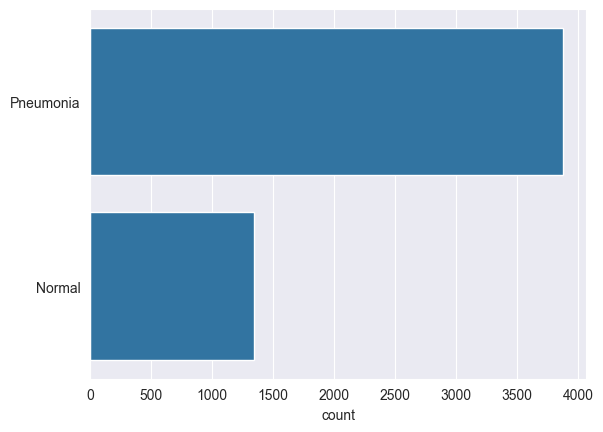

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)       

Text(0.5, 1.0, 'NORMAL')

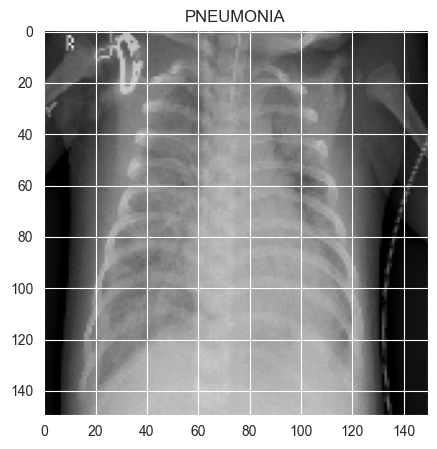

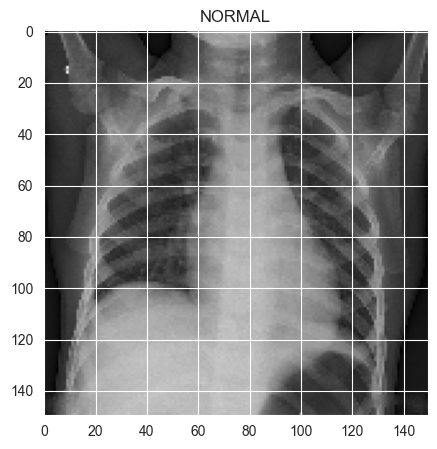

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [9]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [10]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [11]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

C:\Users\Lakashmi nivas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)               │ (None, 150, 150, 32)  │          320 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization           │ (None, 150, 150, 32)  │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 75, 75, 32)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_1 (Conv2D)             │ (None, 75, 75, 64)    │       18,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)             │ (None, 75, 75, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_1         │ (None, 75, 75, 64)    │          256 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_1               │ (None, 38, 38, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_2 (Conv2D)             │ (None, 38, 38, 64)    │       36,928 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_2         │ (None, 38, 38, 64)    │          256 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_2               │ (None, 19, 19, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_3 (Conv2D)             │ (None, 19, 19, 128)   │       73,856 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_1 (Dropout)           │ (None, 19, 19, 128)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_3         │ (None, 19, 19, 128)   │          512 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_3               │ (None, 10, 10, 128)   │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_4 (Conv2D)             │ (None, 10, 10, 256)   │      295,168 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_2 (Dropout)           │ (None, 10, 10, 256)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_4         │ (None, 10, 10, 256)   │        1,024 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_4               │ (None, 5, 5, 256)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten (Flatten)             │ (None, 6400)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 128)           │      819,328 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_3 (Dropout)           │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_1 (Dense)               │ (None, 1)             │ 

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [13]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

C:\Users\Lakashmi nivas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 613ms/step - accuracy: 0.7890 - loss: 1.4151 - val_accuracy: 0.5000 - val_loss: 15.5316 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 597ms/step - accuracy: 0.8846 - loss: 0.2908 - val_accuracy: 0.5000 - val_loss: 16.8542 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9120 - loss: 0.2417  
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 575ms/step - accuracy: 0.9120 - loss: 0.2416 - val_accuracy: 0.5000 - val_loss: 22.1133 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 565ms/step - accuracy: 0.9390 - loss: 0.1574 - val_accuracy: 0.5000 - val_loss: 12.3484 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 595ms/step - accuracy: 0.9481 - loss: 0.1412 - val_accuracy: 0.8125 - val_loss: 0.3044 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 571ms/step - 

In [14]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9209 - loss: 0.2510 
Loss of the model is -  0.2570202648639679
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9209 - loss: 0.2510 
Accuracy of the model is -  91.98718070983887 %


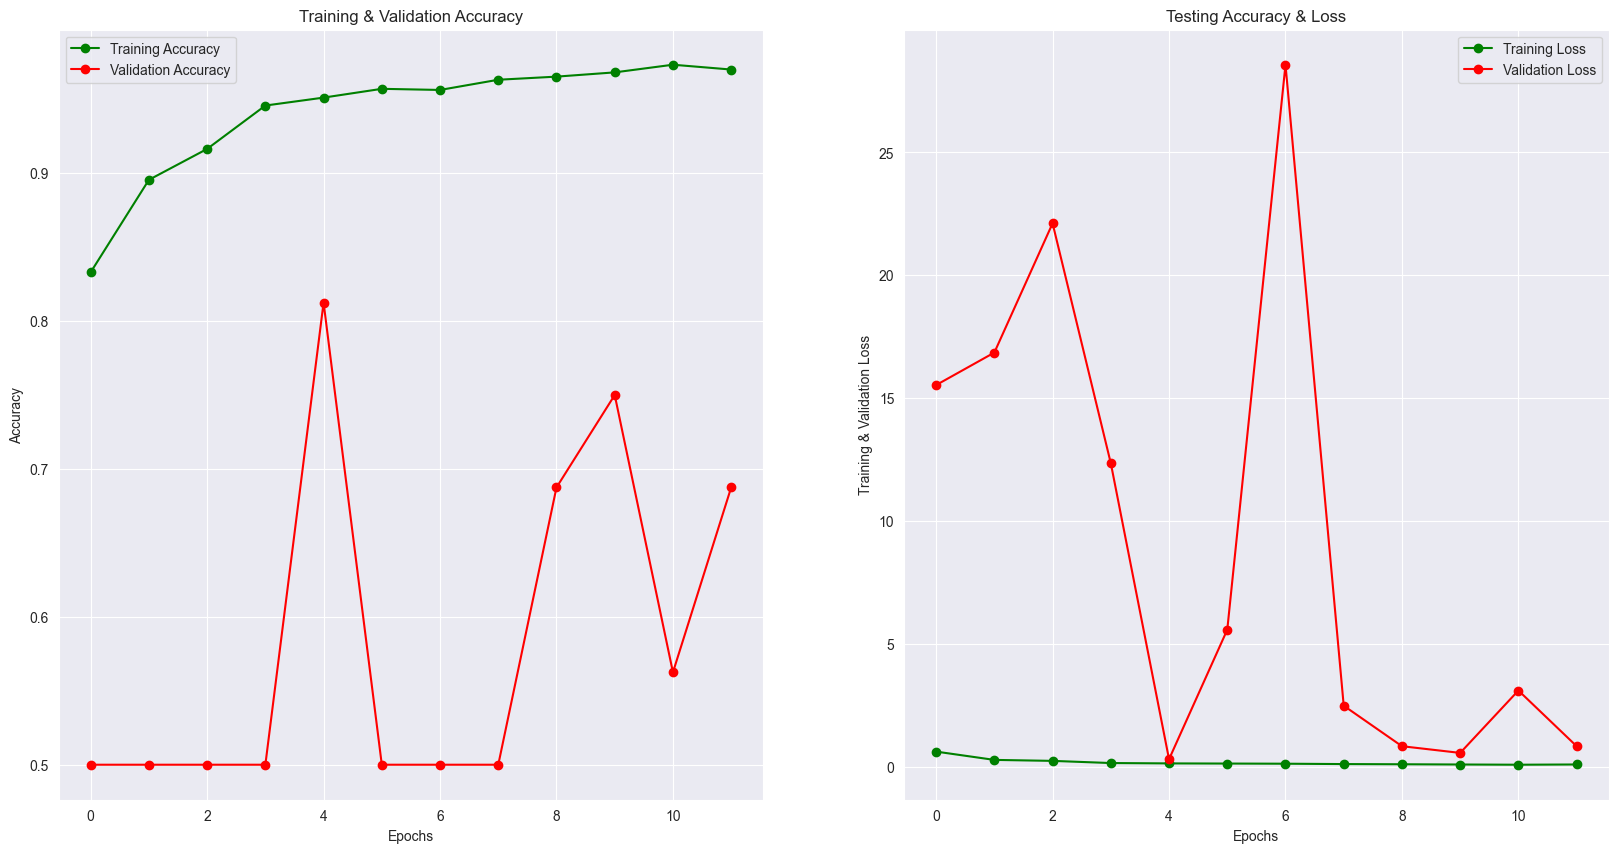

In [15]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [16]:
import numpy as np
# Get raw predictions (probabilities or logits)
predictions = model.predict(x_test)
# Convert to class labels
predicted_classes = np.argmax(predictions, axis=1)
# Print first 15 predictions
print(predicted_classes[:15])

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
print(classification_report(y_test, predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.62      1.00      0.77       390
   Normal (Class 1)       0.00      0.00      0.00       234

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



C:\Users\Lakashmi nivas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lakashmi nivas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lakashmi nivas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [18]:

# Convert probabilities to class labels using a threshold of 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

print(cm)


[[363  27]
 [ 23 211]]


In [19]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

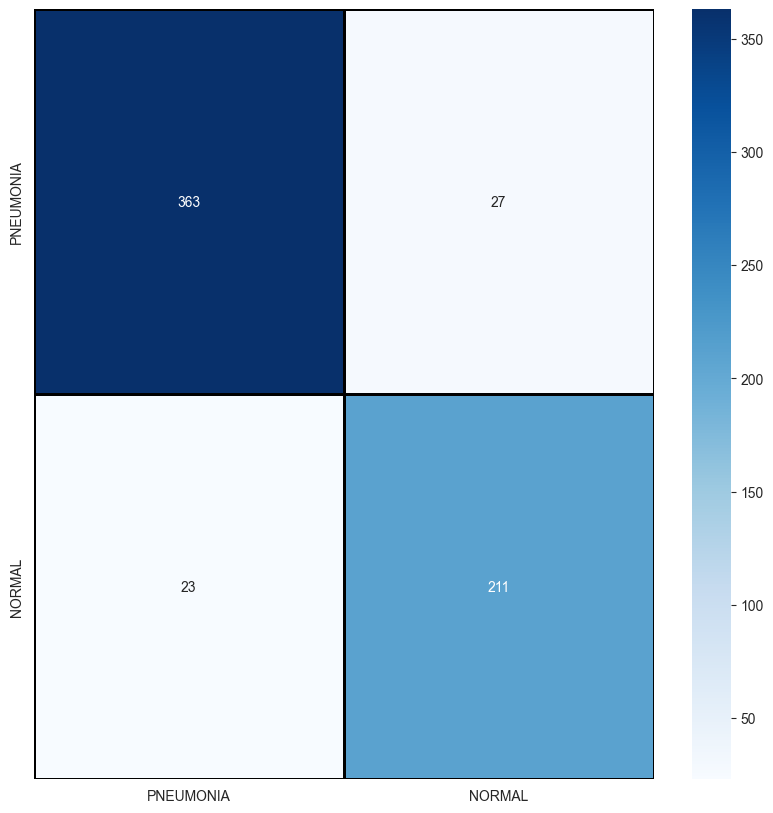

In [20]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)